### Main imports

In [12]:
import os
import requests
from tqdm import tqdm
import zipfile
import numpy
import torch
import torch.optim as optim
import torchvision
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
from PIL import Image
import matplotlib.pyplot as plt
from IPython import display as disp

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print('Device:', device.type)
print('Imports complete.')

Device: cuda
Imports complete.


### Download dataset

In [13]:
# # URL of the file
# url = 'https://data.ncl.ac.uk/ndownloader/articles/24574354/versions/1'

# # make directory if it doesn't exist
# directory = 'classification-data'
# if not os.path.exists(directory):
#     os.makedirs(directory)

# # where to save the downloaded file
# file_path = os.path.join(directory, 'downloaded_file.zip')

# # send a GET request to the URL with stream=True for chunked download
# response = requests.get(url, stream=True)

# # check if the request was successful
# if response.status_code == 200:
#     # total size in bytes from the header
#     total_size = int(response.headers.get('content-length', 0))

#     # progress bar
#     with open(file_path, 'wb') as file, tqdm(
#             desc="Downloading",
#             total=total_size,
#             unit='B',
#             unit_scale=True,
#             unit_divisor=1024,
#     ) as progress_bar:
#         for chunk in response.iter_content(chunk_size=1024):
#             if chunk:
#                 file.write(chunk)
#                 progress_bar.update(len(chunk))

#     print("File downloaded successfully!")

#     # unzipping
#     with zipfile.ZipFile(file_path, 'r') as zip_ref:
#         zip_ref.extractall(directory)
#         print(f"Files unzipped successfully in the '{directory}' directory!")

#     # remove the zip file after extraction
#     os.remove(file_path)
#     print("Zip file removed after extraction.")

# else:
#     print(f"Failed to download the file. Status code: {response.status_code}")

### Import dataset

In [14]:
import os
import numpy
import torch
from torch.utils.data import TensorDataset, DataLoader
import matplotlib.pyplot as plt

class TransformedTensorDataset(TensorDataset):
    def __init__(self, x, y, transform=None):
        super().__init__(x, y)
        self.transform = transform
    
    def __getitem__(self, index):
        x, y = super().__getitem__(index)
        
        # Convert tensor to PIL Image for transforms
        if self.transform:
            x = self.transform(x)  # Apply transforms
        
        return x, y

# directory where the data is stored
data_dir = 'classification-data'

# the .npy files
train_x_path = os.path.join(data_dir, 'train_x.npy')
train_y_path = os.path.join(data_dir, 'train_y.npy')
valid_x_path = os.path.join(data_dir, 'valid_x.npy')
valid_y_path = os.path.join(data_dir, 'valid_y.npy')
test_x_path = os.path.join(data_dir, 'test_x.npy')
test_y_path = os.path.join(data_dir, 'test_y.npy')

# load the data
print("Loading data...")
train_x = numpy.load(train_x_path)
train_y = numpy.load(train_y_path)
valid_x = numpy.load(valid_x_path)
valid_y = numpy.load(valid_y_path)
test_x = numpy.load(test_x_path)
test_y = numpy.load(test_y_path)
print("Data loaded successfully.")

print("Shape of one training sample:", train_x.shape[1:])
print("Shape of one validation sample:", valid_x.shape[1:])
print("Shape of one test sample:", test_x.shape[1:])

train_x = train_x.reshape(-1, 3, 28, 28) 
valid_x = valid_x.reshape(-1, 3, 28, 28) 
test_x = test_x.reshape(-1, 3, 28, 28)

print("Shape of one training sample:", train_x.shape[1:])
print("Shape of one validation sample:", valid_x.shape[1:])
print("Shape of one test sample:", test_x.shape[1:])

# # convert NumPy arrays to PyTorch tensors - HAS BEEN CHANGED FOR THE ABOVE
train_x = torch.from_numpy(train_x).float()
train_y = torch.from_numpy(train_y).long()
valid_x = torch.from_numpy(valid_x).float()

valid_y = torch.from_numpy(valid_y).long()
test_x = torch.from_numpy(test_x).float()
test_y = torch.from_numpy(test_y).long()

# # create TensorDataset instances
train_dataset = TensorDataset(train_x, train_y)
valid_dataset = TensorDataset(valid_x, valid_y)
test_dataset = TensorDataset(test_x, test_y)

# train_transform = transforms.Compose([
#     transforms.RandomHorizontalFlip(),
#     transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
# ])

# test_transform = transforms.Compose([
#     transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]),
# ])

# train_dataset = TransformedTensorDataset(train_x, train_y, transform=train_transform)
# valid_dataset = TransformedTensorDataset(valid_x, valid_y, transform=test_transform)
# test_dataset = TransformedTensorDataset(test_x, test_y, transform=test_transform)

train_dataset = TensorDataset(train_x, train_y)
valid_dataset = TensorDataset(valid_x, valid_y)
test_dataset = TensorDataset(test_x, test_y)

# batch size
batch_size = 64

# DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
valid_loader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=False, drop_last=False)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, drop_last=False)

# Helper function to cycle through the data indefinitely
def cycle(iterable):
    while True:
        for x in iterable:
            yield x

# iterators for training, validation, and test loaders
train_iterator = iter(cycle(train_loader))
valid_iterator = iter(cycle(valid_loader))
test_iterator = iter(cycle(test_loader))

# class names
class_names = [str(i) for i in range(20)]

# dataset sizes
print(f'> Size of training dataset: {len(train_dataset)}')
print(f'> Size of validation dataset: {len(valid_dataset)}')
print(f'> Size of test dataset: {len(test_dataset)}')


Loading data...
Data loaded successfully.
Shape of one training sample: (3, 28, 28)
Shape of one validation sample: (3, 28, 28)
Shape of one test sample: (3, 28, 28)
Shape of one training sample: (3, 28, 28)
Shape of one validation sample: (3, 28, 28)
Shape of one test sample: (3, 28, 28)
> Size of training dataset: 45000
> Size of validation dataset: 15000
> Size of test dataset: 10000


**View some of the test dataset**

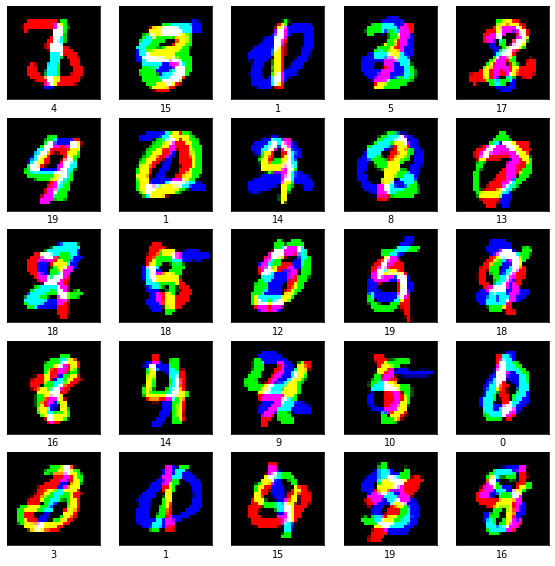

In [15]:
plt.rcParams['figure.dpi'] = 70
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    img = test_loader.dataset[i][0].numpy().transpose(1, 2, 0)
    img = numpy.clip(img, 0, 1)
    plt.imshow(img)
    plt.xlabel(class_names[test_loader.dataset[i][1]])
plt.show()

### Attempt 1 - 84% accuracy

In [16]:
class EnhancedCNN(nn.Module):
    def __init__(self):
        super(EnhancedCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 30, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm2d(30)
        self.conv2 = nn.Conv2d(30, 40, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm2d(40)
        self.conv3 = nn.Conv2d(40, 60, kernel_size=3, padding=1)
        self.bn3 = nn.BatchNorm2d(60)
        self.conv4 = nn.Conv2d(60, 70, kernel_size=3, padding=1)
        self.bn4 = nn.BatchNorm2d(70)
    
        self.fc1 = nn.Linear(70, 100)
        self.fc2 = nn.Linear(100, 150)
        self.fc3 = nn.Linear(150, 20)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.bn1(x)
        x = F.max_pool2d(x, 2)

        x = F.relu_(self.conv2(x))
        x = self.bn2(x)
        x = F.max_pool2d(x, 2)


        x = F.relu(self.conv3(x)) 
        x = self.bn3(x)
        x = F.max_pool2d(x, 2)

        x = F.relu(self.conv4(x)) 
        x = self.bn4(x)
        x = F.max_pool2d(x, 2)

        x = x.view(x.size(0), -1)

        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)

        return x

N = EnhancedCNN().to(device)

print(f'> Number of parameters {len(torch.nn.utils.parameters_to_vector(N.parameters()))}')

criterion = nn.CrossEntropyLoss(label_smoothing=0.1)

optimiser = torch.optim.AdamW(N.parameters(), lr=0.0018)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimiser, mode='min', factor=0.225, patience=6)

plot_data = []
steps = 0
best_test_acc = 0.0


> Number of parameters 96880


### Main training and testing loop - Attempt 1

Steps: 10000 | LR: 0.001800 | Train Loss: 0.8068 | Train Acc: 0.937±0.035 | Test Acc: 0.862±0.041 | Best: 0.862


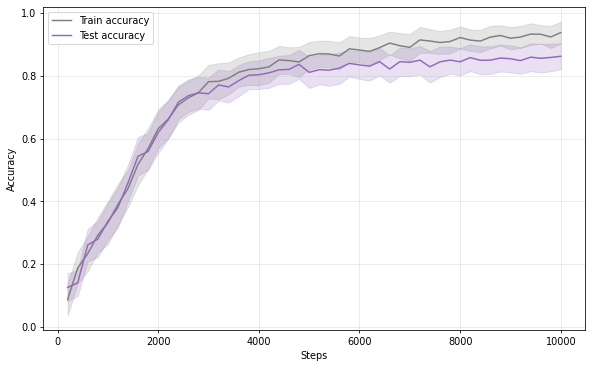

In [17]:
import torch
import numpy as np
from torch.cuda.amp import autocast, GradScaler
import matplotlib.pyplot as plt
from IPython import display
from collections import deque

steps = 0
max_steps = 10000
best_test_acc = 0.0
plot_data = []

# Initialize gradient scaler for mixed precision training
scaler = GradScaler()

# Learning rate warmup setup
warmup_steps = 1000  # Increased for 200 iterations per epoch
initial_lr = optimiser.param_groups[0]['lr']

# Loss tracking for stability monitoring
loss_window = deque(maxlen=50)
best_loss = float('inf')
patience = 5
no_improve_count = 0

while steps < max_steps:
    # Pre-allocate arrays for metrics with expected size
    train_loss_arr = np.zeros(200)  # Matches your iteration count
    train_acc_arr = np.zeros(200)
    
    # Training phase
    N.train()
    for i in range(200):  # Your specified iteration count
        # Implement learning rate warmup
        if steps < warmup_steps:
            lr = initial_lr * (steps + 1) / warmup_steps
            for param_group in optimiser.param_groups:
                param_group['lr'] = lr
        
        # Get next batch with error handling
        try:
            x, t = next(train_iterator)
        except StopIteration:
            train_iterator = iter(train_loader)
            x, t = next(train_iterator)
        
        x, t = x.to(device), t.to(device)
        
        # Mixed precision training
        with autocast():
            optimiser.zero_grad(set_to_none=True)  # More efficient than zero_grad()
            p = N(x)
            pred = p.argmax(dim=1, keepdim=True)
            loss = criterion(p, t)
        
        # Scale gradients and backpropagate
        scaler.scale(loss).backward()
        
        # Gradient clipping for stability
        scaler.unscale_(optimiser)
        torch.nn.utils.clip_grad_norm_(N.parameters(), max_norm=1.0)
        
        # Optimizer step with scaling
        scaler.step(optimiser)
        scaler.update()
        
        # Store metrics efficiently
        train_loss_arr[i] = loss.item()
        train_acc_arr[i] = pred.eq(t.view_as(pred)).float().mean().item()
        loss_window.append(loss.item())
        
        steps += 1
        
        # Check for loss explosion
        if not numpy.isfinite(loss.item()):
            print("Warning: Loss exploded. Loading best model and reducing learning rate.")
            N.load_state_dict(torch.load('best_model.pth'))
            for param_group in optimiser.param_groups:
                param_group['lr'] *= 0.5
            break
    
    # Evaluation phase
    N.eval()
    test_acc_list = []
    
    with torch.no_grad():
        for x, t in test_loader:
            x, t = x.to(device), t.to(device)
            with autocast():
                p = N(x)
                pred = p.argmax(dim=1, keepdim=True)
            test_acc_list.append(pred.eq(t.view_as(pred)).float().mean().item())
    
    # Calculate metrics efficiently
    avg_train_loss = numpy.mean(train_loss_arr)
    avg_train_acc = numpy.mean(train_acc_arr)
    avg_test_acc = numpy.mean(test_acc_list)
    
    # Learning rate scheduling
    scheduler.step(avg_train_loss)
    
    # Early stopping logic
    if avg_train_loss < best_loss:
        best_loss = avg_train_loss
        no_improve_count = 0
    else:
        no_improve_count += 1
        
    if no_improve_count >= patience:
        print(f"Early stopping triggered at step {steps}")
        break
    
    # Save best model with complete state
    if avg_test_acc > best_test_acc:
        best_test_acc = avg_test_acc
    
    # Store plotting data
    plot_data.append([
        steps, 
        avg_train_acc,
        np.std(train_acc_arr),
        avg_test_acc,
        np.std(test_acc_list)
    ])
    
    # Print progress with current learning rate
    print(
        f'Steps: {steps:5d} | '
        f'LR: {optimiser.param_groups[0]["lr"]:.6f} | '
        f'Train Loss: {avg_train_loss:.4f} | '
        f'Train Acc: {avg_train_acc:.3f}±{numpy.std(train_acc_arr):.3f} | '
        f'Test Acc: {avg_test_acc:.3f}±{numpy.std(test_acc_list):.3f} | '
        f'Best: {best_test_acc:.3f}'
    )
    
    # Create visualization
    plt.figure(figsize=(10, 6))
    steps_data = [x[0] for x in plot_data]
    plt.plot(steps_data, [x[1] for x in plot_data], '-', color='tab:grey', label='Train accuracy')
    plt.fill_between(steps_data,
                    [x[1]-x[2] for x in plot_data],
                    [x[1]+x[2] for x in plot_data],
                    alpha=0.2, color='tab:grey')
    plt.plot(steps_data, [x[3] for x in plot_data], '-', color='tab:purple', label='Test accuracy')
    plt.fill_between(steps_data,
                    [x[3]-x[4] for x in plot_data],
                    [x[3]+x[4] for x in plot_data],
                    alpha=0.2, color='tab:purple')
    plt.xlabel('Steps')
    plt.ylabel('Accuracy')
    plt.legend(loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.show()
    display.clear_output(wait=True)

## Inference on data

This is useful for analysis but is entirely optional

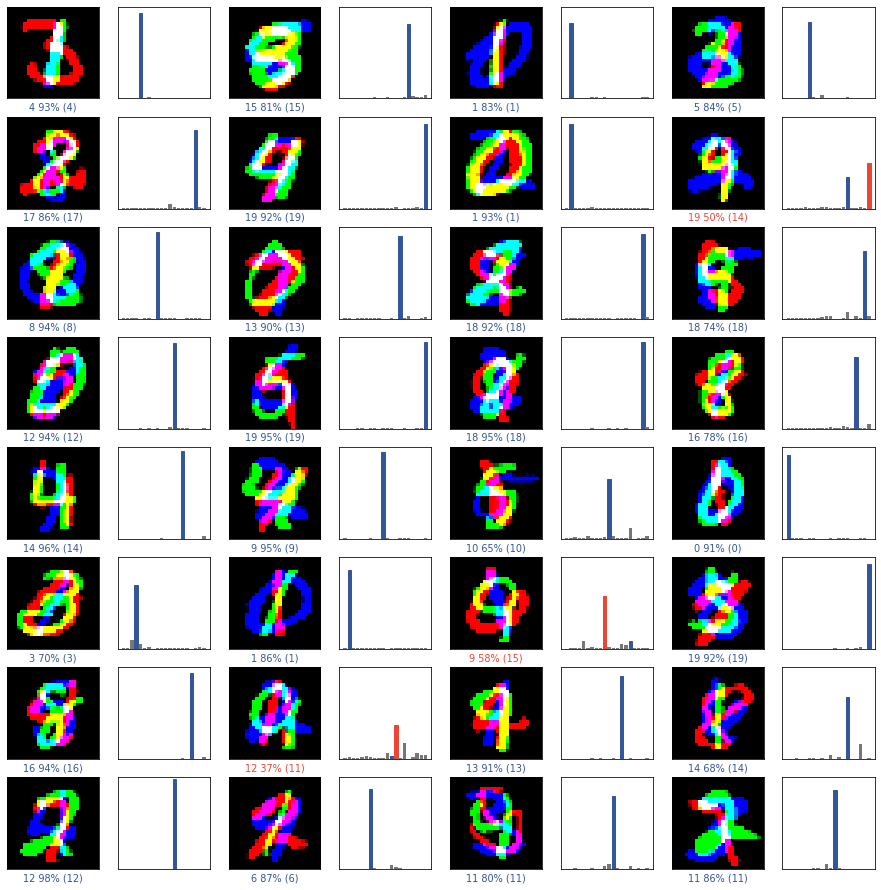

In [18]:
def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array[i], true_label[i], img[i]
    img = numpy.clip(img, 0, 1)
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    img = numpy.transpose(img, (1, 2, 0))
    plt.imshow(img)

    predicted_label = numpy.argmax(predictions_array)
    color = '#335599' if predicted_label == true_label else '#ee4433'

    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                  100*numpy.max(predictions_array),
                                  class_names[true_label]),
                                  color=color)

def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array[i], true_label[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])
    thisplot = plt.bar(range(20), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = numpy.argmax(predictions_array)

    thisplot[predicted_label].set_color('#ee4433')
    thisplot[true_label].set_color('#335599')

test_images, test_labels = next(test_iterator)
test_images, test_labels = test_images.to(device), test_labels.to(device)
test_preds = torch.softmax(N(test_images), dim=1).data.cpu().numpy()
num_rows = 8
num_cols = 4
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2*num_cols, 2*i+1)
    plot_image(i, test_preds, test_labels.cpu().numpy(), test_images.cpu().numpy()) # Used .numpy() here
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i, test_preds, test_labels.cpu().numpy())